Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [2]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/aligned/'
# Principales
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'Customer.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'Product.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'Promotion.csv', encoding='latin-1')
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')


## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [3]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00


### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [4]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
CarrierTrackingNumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerPONumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevisionNumber,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
OrderQuantity,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
UnitPriceDiscountPct,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DiscountAmount,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,60398.0,437.557932,118.088390,214.0000,359.0000,479.0000,529.0000,606.0000
CustomerKey,60398.0,18841.685420,5432.430404,11000.0000,14003.0000,18143.0000,23429.7500,29483.0000
PromotionKey,60398.0,1.041839,0.342605,1.0000,1.0000,1.0000,1.0000,14.0000
CurrencyKey,60398.0,69.845326,42.146363,6.0000,19.0000,100.0000,100.0000,100.0000
SalesTerritoryKey,60398.0,6.244462,2.961150,1.0000,4.0000,7.0000,9.0000,10.0000
SalesOrderLineNumber,60398.0,1.886321,1.016328,1.0000,1.0000,2.0000,2.0000,8.0000
UnitPrice,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ExtendedAmount,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ProductStandardCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942
TotalProductCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942


La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

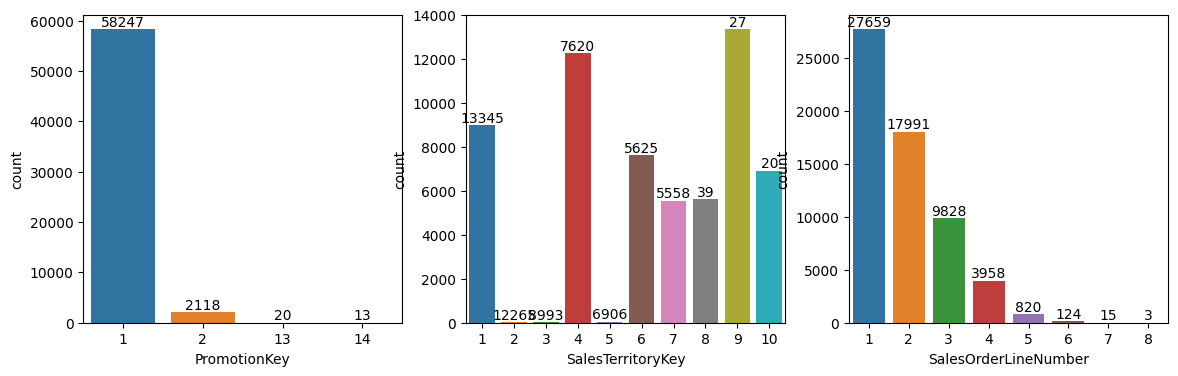

In [6]:
sales = pd.read_csv(myPath + 'cleaned/SALES_clean.csv', encoding='latin-1', \
    parse_dates=['OrderDate', 'DueDate', 'ShipDate'], infer_datetime_format=True)
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = sns.countplot(data = df, ax=axes[0], x='PromotionKey')
abs_values = df['PromotionKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(data= df, ax=axes[1], x='SalesTerritoryKey')
abs_values = df['SalesTerritoryKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(ax=axes[2], x=df['SalesOrderLineNumber'])
abs_values = df['SalesOrderLineNumber'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.
    * ProductKey
    * CustomerKey
    * PromotionKey
    * CurrencyKey
    * SalesTerritoryKey

In [7]:
num_types = sales.dtypes.to_frame('dtypes')
min_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value = sales.describe().T[['min','max']].round(1)
my_summary = pd.concat([num_types, min_col_len, max_col_len, min_max_value], axis=1)
sales_serie = sales['SalesOrderNumber'].str[2:]
# En SalesOrderNumber se ordenan los datos omitiendo 'CO'
min = 'CO'+ str(pd.to_numeric(sales_serie).min())
max = 'CO'+ str(pd.to_numeric(sales_serie).max())
dates = sales[['OrderDate','DueDate','ShipDate']]
my_summary.loc['SalesOrderNumber', ['min','max']] = [min, max]
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'min'] = dates.min()
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'max'] = dates.max()
my_summary

,dtypes,min_length,max_length,min,max
ProductKey,int64,3,3,214.0,606.0
CustomerKey,int64,5,5,11000.0,29483.0
PromotionKey,int64,1,2,1.0,14.0
CurrencyKey,int64,1,3,6.0,100.0
SalesTerritoryKey,int64,1,2,1.0,10.0
SalesOrderNumber,object,7,7,CO43697,CO75123
SalesOrderLineNumber,int64,1,1,1.0,8.0
UnitPrice,float64,3,6,2.3,3578.3
ExtendedAmount,float64,3,6,2.3,3578.3
ProductStandardCost,float64,3,6,0.9,2171.3


## 2. CUSTOMERS
Preguntas de la visualización general:
* ¿Es de utilidad una llave alterna de CustomerKey?
* ¿Qué información aporta NameStyle (solo existen valores falsos y nulos)?
* ¿Los primeros dígitos en AddressLine1 son el código postal?
* ¿Los números de teléfono con más de 10 dígitos añadieron al principio LADA?
* ¿CommuteDistance es la distancia de los clientes al punto de venta?

In [8]:
# cust.info() #18485 entradas, 29 columnas
cust.head(4)

,CustomerKey,GeographyKey,CustomerAlternateKey,Title,FirstName,MiddleName,LastName,NameStyle,BirthDate,MaritalStatus,...,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,AddressLine2,Phone,DateFirstPurchase,CommuteDistance
0,11000,26,AW00011000,NaN,Jon,V,Yang,False,1971-10-06,M,...,Professional,Profesional,Cadre,1.0,0.0,3761 N. 14th St,NaN,1 (11) 500 555-0162,2011-01-19,1-2 Miles
1,11001,37,AW00011001,NaN,Eugene,L,Huang,False,1976-05-10,S,...,Professional,Profesional,Cadre,0.0,1.0,2243 W St.,NaN,1 (11) 500 555-0110,2011-01-15,0-1 Miles
2,11002,31,AW00011002,NaN,Ruben,NaN,Torres,False,1971-02-09,M,...,NaN,NaN,Cadre,1.0,1.0,5844 Linden Land,NaN,1 (11) 500 555-0184,2011-01-07,2-5 Miles
3,1002,31,AW00011002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Professional,Profesional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modificaciones en la tabla customers
* El cuarto registro en la tabla es un duplicado del tercero, con información complementaria. Hay que fusionar esa información.
* El 1 (11) en la columna Phone, parece ser información repetitiva. El formato de número deberá ser forzosamente XXX-XXX-XXXX, o bien 10 dígitos seguidos.
* La palabra "Miles" en la columna CommuteDistance es información redundante. Se debe eliminar. Además, contiene información categórica (0-1,2-5...), que puede ser mapeada con números para disminuir el volumen de datos.
* BirthDate y DateFirstPurchase deben guardarse en formato de fecha.
* Title contiene colamente 101 registros, Suffix 3 y AddressLine2 312. Considerando que el total de registros es de 18485, estas columnas tienen un porcentaje de datos del 0.54, 0.016 y 1.7%, respectivamente, por lo que las columnas no generarán conocimientos de interés y se eliminarán.

In [12]:
prod.isnull().sum()

ProductKey                 0
ProductAlternateKey       21
ProductSubcategoryKey    226
WeightUnitMeasureCode    321
SizeUnitMeasureCode      247
EnglishProductName       103
SpanishProductName       283
FrenchProductName        257
StandardCost             136
FinishedGoodsFlag         88
Color                    167
SafetyStockLevel          88
ReorderPoint             227
ListPrice                273
Size                     233
SizeRange                183
Weight                   242
DaysToManufacture        223
ProductLine              230
DealerPrice              306
Class                    283
Style                    159
ModelName                 89
EnglishDescription       153
FrenchDescription        304
StartDate                492
EndDate                  607
Status                   607
dtype: int64